Figure-SI2.ipynb
------------------------------------------------------------------------------
Purpose:  
- Generate Figure SI2 (panels A & B) illustrating sample representativeness across countries/functional urban areas. 

Usage:
- Change fp variable to replication filepath.
- Run all cells.
  
Requirements:
- Python 3
- Packages: matplotlib 3.9.2, pandas 2.2.2, numpy 1.26.4, scipy 1.13.0, statsmodels 0.14.1

Inputs:
- sample_statistics/sample_nonus/sample_sizes_fua_{country}.csv (FUA-level sample size, produced on Spectus platform using process_trips_into_outputs_intl.ipynb)
- fua/FUA.csv (FUA-level population, produced from Global Human Settlement Layer data using processing_GHSL.ipynb)

Outputs:
- figures/figSI1.png


In [1]:
fp = '../'
fp_input = fp + 'data/'
fp_output = fp + 'figures/'


In [2]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Helvetica'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm

### Define helper functions.

In [3]:
def scatter(xcol,ycol,xname,yname,axis,color,logx=True,logy=True,fit_thresh=None,label=None,annotate=True,linecolor='black',sample_size=None):
    axis.scatter(xcol,ycol,color=color,alpha=.6,zorder=1,s=15)

    if fit_thresh:
        filterer = xcol>fit_thresh
        xcol = xcol[filterer]
        ycol = ycol[filterer]
    
    xs = np.linspace(np.min(xcol),np.max(xcol),100)

            
    if logx:
        axis.set_xscale('log')
        xcol = np.log(xcol)
    if logy:
        axis.set_yscale('log')
        ycol = np.log(ycol)
        
    r = pearsonr(xcol,ycol)
    r = np.round(r[0],3)


    mod = sm.OLS(ycol,sm.add_constant(xcol)).fit()
    beta = np.round(mod.params['total_population'],3)
    bse = np.round(mod.bse['total_population'],3)
    if logy:
        ys = [x**beta*np.exp(mod.params['const']) for x in xs]
    else:
        ys = [x*beta + mod.params['const'] for x in xs]

    axis.plot(xs,ys,color=linecolor)
    axis.grid(linestyle='dotted',zorder=0)

    axis.set_xlabel(xname)
    axis.set_ylabel(yname)

    axis.annotate(label,xy=(-0.125,1.05), xycoords='axes fraction',
                fontsize=16, fontname = 'Arial', weight='bold')

    if annotate:
 
        axis.text(x=0.1,y=.9,s=r'$\beta$ = '+f'{beta}' + r'$\pm$' + f'{bse}', transform=axis.transAxes)
        axis.text(x=0.1,y=.85,s=f'R = {r}', transform=axis.transAxes)
        if sample_size != None:
            axis.text(x=0.1,y=.8,s=f'N = {sample_size}', transform=axis.transAxes)

    else:
        return((beta,bse,r))


### Read in data & create figure.

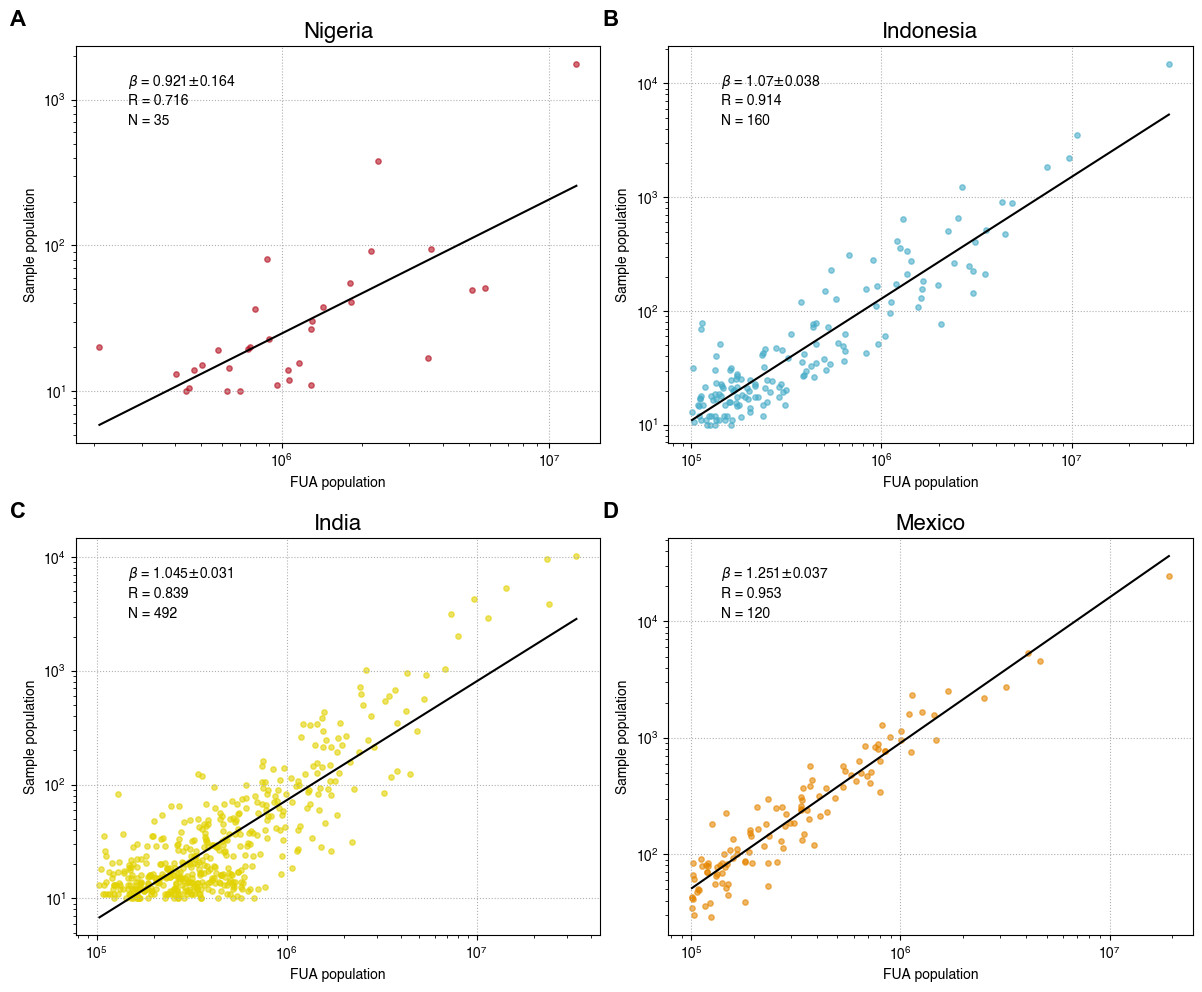

In [6]:
colors = {'ID': '#46ACC8',
            'IN': '#e2d200',
            'MX': '#E58601',
            'NG': '#B40F20'}

darkcolors = {'ID': '#0A81A1',
              'IN': '#A79B00',
              'MX': '#AF6703',
              'NG': '#920513' 
            }

labels = ['A','B','C','D']

countries = ['NG','ID','IN','MX']
countries_readable = {'NG':'Nigeria','ID':'Indonesia','IN':'India','MX':'Mexico'}

fig,axs = plt.subplots(2,2,figsize=(12,10))
mo_counts = []
i=0

for country in countries:
    patches1 = []

    sample_size_fua = pd.read_csv(f'{fp_input}/sample_statistics/sample_nonus/sample_sizes_fua_{country}.csv')

    sample_size_fua.columns = sample_size_fua.columns.str.lower()
    sample_size_fua['users'] = sample_size_fua.users.astype(int)
    
    fua_pop = pd.read_csv(f'{fp_input}fua/FUA.csv')
    fua_pop = fua_pop.rename(columns={'eFUA_ID':'home_fua_id','FUA_p_2020':'total_population'})[['home_fua_id','total_population']]
    
    sample_size_fua_mo = sample_size_fua.groupby(['filter','home_fua_id']).agg({'users':'mean'}).reset_index().merge(fua_pop)
    n = len(set(sample_size_fua_mo.home_fua_id))

    scatter(sample_size_fua_mo[sample_size_fua_mo['filter']==1].total_population,
            sample_size_fua_mo[sample_size_fua_mo['filter']==1].users,
            'FUA population',
            'Sample population',
            axis = axs[i//2,i%2],
            color = colors[country],
            label = labels[i],
            sample_size = n)
    axs[i//2,i%2].set_title(countries_readable[countries[i]],fontsize=16)    
    i+=1
    
fig.tight_layout()

fig.savefig(f'{fp_output}figSI2.png',dpi=300)

